In [165]:
import pandas as pd
from datetime import datetime
import numpy as np
import re

In [166]:
animes = pd.read_csv("data/animes.csv", index_col=0)
profiles = pd.read_csv("data/profiles.csv", index_col=0)
#review = pd.read_csv("data/review.csv")

# Linhas duplicadas

Muitas linhas duplicadas foram encontradas, removendo:

In [167]:
animes = animes[~animes.index.duplicated()]
animes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16216 entries, 28891 to 16934
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   title       16216 non-null  object 
 1   synopsis    15453 non-null  object 
 2   genre       16216 non-null  object 
 3   aired       16216 non-null  object 
 4   episodes    15724 non-null  float64
 5   members     16216 non-null  int64  
 6   popularity  16216 non-null  int64  
 7   ranked      14553 non-null  float64
 8   score       15875 non-null  float64
 9   img_url     16051 non-null  object 
 10  link        16216 non-null  object 
dtypes: float64(3), int64(2), object(6)
memory usage: 1.5+ MB


In [168]:
profiles = profiles[~profiles.index.duplicated()]
profiles.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47885 entries, DesolatePsyche to srry4apologizng
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   gender           30878 non-null  object
 1   birthday         26848 non-null  object
 2   favorites_anime  47885 non-null  object
 3   link             47885 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


# Perfis dos usuários

### Resgatando datas de aniversário

O objetivo principal nesta tarefa de *parsing* é preservar a informação idade do usuário, para isto, os *strings* com a informação do ano de nascimento (ou algo que possa ser usado como tal) precisam ser mantidos, todos os outros podem ser descartados.

In [169]:
def parse_birth_dates(inp: str | datetime) -> datetime | None:
    is_datetime = isinstance(inp, datetime)
    is_string = isinstance(inp, str)
    
    if inp==np.nan:
        return None

    # typical cases, people born before 2000
    formats = (
        # complete information:
        "%b %d, %Y", 
        # day missing:
        "%b %Y", "%m, %Y", 
        # month missing:
        "%d, %Y",
        # day and month missing:
        "%Y", "%y")

    if is_datetime:
        return inp
    else:
        for form in formats:
            try:
                return datetime.strptime(inp, form)
            except:
                continue

    # special cases, people born in the 2000s and after
    curr_year = str(pd.to_datetime("today").year)
    max_valid = int(f"{curr_year}"[2:])

    # parsing "%y" with single digits, month and day missing (might be "%d" being treated as the former)
    # leaving uncommented due to low impact on the data
    if is_string and (len(inp) < 3):
        try:
            if (int(inp) < max_valid):
                inp = f"{int(inp):02}"
                return datetime.strptime(inp, "%y")
            else:
                return inp
        except:
            pass
            
    # parsing "%b %y", day missing (probably "%b %d" being treated as the former)
    # leaving commented
    # else:
    #     try:
    #         
    #         str_elements = string.split(" ")
    #         if int(str_elements[1]) < max_valid:
    #             string = f"{str_elements[0]} 20{int(str_elements[1]):02}"
    #             return datetime.strptime(string, format="%b %Y")
    #     except:
    #         pass
            
    return None

In [170]:
# Know which dates were not parsed    
dict_transform = {x: parse_birth_dates(x) for x in profiles["birthday"].unique()}
parsed = profiles["birthday"].map(dict_transform)

not_parsed_names = parsed.loc[parsed.isnull()].index
not_parsed_values = profiles["birthday"].loc[not_parsed_names]
nan_amount = not_parsed_values.isnull().sum()

print(f"Not parsed: \n{list(not_parsed_values.unique())}")
print(
    f"\nAmount of not parsed: {len(not_parsed_values) - nan_amount}",
    f"Amount of nan: {nan_amount}",
    sep="\n")

Not parsed: 
[nan, 'Sep 5', 'Oct 6', 'Aug 23', 'Jun 2', 'Jul 17', 'Sep 25', 'Aug 31', 'Mar 19', 'Sep 26', 'Jun 30', 'Apr 10', 'Jun 22', 'Jul 11', 'Apr 12', 'May 14', 'Sep 28', 'Jan 8', 'Jun 15', 'Oct 11', 'Dec 27', 'Jun 1', 'Aug 21', 'Nov 12', 'Oct 20', 'Nov 13', 'Jul 26', 'Nov 25', 'Oct 2', 'Apr 21', 'Jul 23', 'May 26', 'Feb 12', 'Feb 24', 'Oct 16', 'Aug 28', 'Oct 4', 'Dec 8', 'Apr 27', 'Mar 21', 'Oct 19', 'Dec 9', 'Aug 13', 'Dec 7', 'Jan 17', 'May 13', 'Mar 16', 'Jul 4', 'May 9', 'Jun 23', 'Jun 29', 'Mar 26', 'Sep 12', 'Nov 23', 'May 11', 'Apr 6', 'Dec 3', 'Mar', 'Dec 26', 'Oct', 'Jun 19', 'Mar 25', 'Apr 30', 'Nov 10', 'Dec 29', 'Sep 1', 'Aug 30', 'May 31', 'Dec 21', 'Sep 10', 'Mar 7', 'Apr 18', 'Feb 8', 'Nov 14', 'May 23', 'Feb 20', 'Jun 14', 'Jul 18', 'Feb 25', 'Jan 31', 'Jan 14', 'Jun 12', 'Mar 18', 'Aug 17', 'Nov 16', 'Dec 2', 'Sep 6', 'Sep 18', 'Jan 15', 'Oct 18', 'Jun 24', 'Jan 27', 'Dec 22', 'Jun 8', 'Aug 5', 'Mar 5', 'Aug 29', 'Oct 12', 'Feb 26', 'Feb 17', 'Sep 27', 'Apr 13',

### Obtendo as idades

Agora podemos obter a idade da maioria dos usuários:

<Axes: >

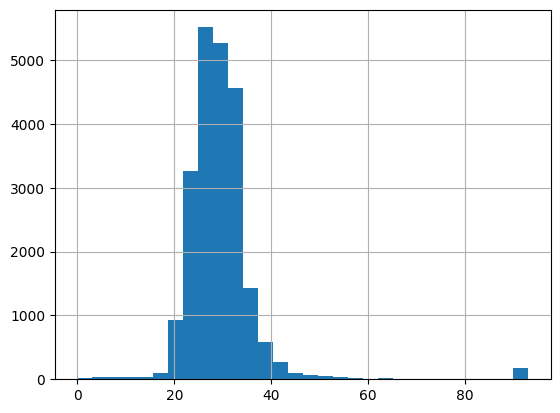

In [171]:
birthday_is_date = pd.api.types.is_datetime64_any_dtype(profiles["birthday"])
today = pd.to_datetime('today')

if not birthday_is_date:
    profiles["birthday"] = profiles["birthday"].map(dict_transform)
    profiles["birthday"] = pd.to_datetime(profiles["birthday"])

profiles["user_age"] = today.year - profiles["birthday"].dt.year
profiles["user_age"].hist(bins=30)

# Obtendo lista de animes favoritos

Os animes favoritos estão relacionados como "['anime1', 'anime2', ...]", vamos ter que obter estas informações como listas do python para relacionar gênero e idade dos usuários e suas categorias favoritas de animes.

Por incrível que possa parecer, esta transformação vai ser mais simples do que parece.

In [172]:
def parse_as_list(string):
    if type(string) == str:
        if string == "[]": 
            return None
        line = re.sub(r"(\[|\]|')", "", string)
        return line.split(", ")
    else:
        return string
    
profiles["favorites_anime"] = profiles["favorites_anime"].apply(parse_as_list)
animes["genre"] = animes["genre"].apply(parse_as_list)

## Adicionando informação de gêneros favoritos

Agora precisamos adicionar uma coluna para cada gênero possível em `profiles`, cada linha de dados deve incluir a quantidade de ocorrências de determinado gênero na lista de animes do usuário.

In [173]:
unique_genres = []
for row in animes["genre"]:
    if row:
        for item in row:
            if item not in unique_genres:
                unique_genres.append(item)

print(*unique_genres, sep=" // ")

Comedy // Sports // Drama // School // Shounen // Music // Romance // Sci-Fi // Adventure // Mystery // Fantasy // Action // Military // Magic // Supernatural // Vampire // Slice of Life // Demons // Historical // Super Power // Mecha // Parody // Samurai // Seinen // Police // Psychological // Josei // Space // Kids // Shoujo Ai // Ecchi // Shoujo // Horror // Shounen Ai // Cars // Martial Arts // Game // Thriller // Dementia // Harem // Hentai // Yaoi // Yuri


Agora vamos podemos usar a nossa lista de gêneros para provoar `profiles` com uma coluna para cada gênero, por enquanto os valores serão todos `0`. 

In [174]:
for genre in unique_genres:
    profiles[genre] = 0

Com as colunas prontas para receber os novos valores, vamos adicionar os totais de animes vistos para cada gênero.

In [175]:
dict_of_genres = {str(id): genres for id, genres in zip(animes.index, animes["genre"])}

for user in profiles.index[:4]:
    anime_ids = profiles.loc[user, "favorites_anime"]
    genres = [dict_of_genres[str(id)] if id else None for id in anime_ids]

    if genres == [None]:
        continue
    
    genre_counts = {}
    for sublist in genres:
        for genre in sublist:
            if genre in genre_counts:
                genre_counts[genre] += 1
            else:
                genre_counts[genre] = 1
    # !!! Running this part multiple times will add the quantities multiple times
    for genre in genre_counts.keys():
        profiles.loc[user, genre] = (profiles.loc[user, genre] + genre_counts[genre])

Como cada anime apresenta vários gêneros diferentes,

1. as somas dos valores nessas novas colunas deve ter pelomenos que a quantidade de títulos assistidos,
2. mas cada valor único deve ser menor ou igual à quantidade de títulos.

Vamos usar isto para testar o nosso algorítmo nesta etapa do processamento de dados.

In [187]:
profiles["animes_watched"] = profiles["favorites_anime"].apply(lambda x: len(x) if x else 0)

# first test:
test_1 = np.array(profiles[unique_genres].sum(axis="columns")) 
print("Test 1 fails:", np.sum(test_1 < profiles["animes_watched"]))

# second test:


Test 1 fails: 37459
